## Part I : EDA - Exploratory Data Analysis

For this task, we're going to conduct an exploratory data analysis on the store sales dataset. 

In [1]:
# Import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Set pandas options to display floats without scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

sns.set_theme()

### 1. Load the dataset

Won't use oil from the original Kaggle.

Data files:
1) store_sales_raw
2) holidays_events.csv
4) stores.csv
5) transactions.csv

In [2]:
# Load all data
store_sales_df = pd.read_csv(r'../data/store_sales_raw.csv')
holidays_df = pd.read_csv(r'../data/holidays_events.csv')
store_df = pd.read_csv(r'../data/stores.csv')

In [3]:
#
store_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029400 entries, 0 to 3029399
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 138.7+ MB


In [4]:
#
holidays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [5]:
#
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [6]:
# Convert to Datetime for the date column of store_sales_df and holidays_df
store_sales_df['date'] = pd.to_datetime(store_sales_df.date)
holidays_df['date'] = pd.to_datetime(holidays_df.date)

In [7]:
store_sales_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00000,0.00000
1,1,2013-01-01,1,BABY CARE,0.00000,0.00000
2,2,2013-01-01,1,BEAUTY,0.00000,0.00000
3,3,2013-01-01,1,BEVERAGES,0.00000,0.00000
4,4,2013-01-01,1,BOOKS,0.00000,0.00000
...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,1.00000,NaN
3029396,3029396,2017-08-31,9,PREPARED FOODS,0.00000,NaN
3029397,3029397,2017-08-31,9,PRODUCE,1.00000,NaN
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9.00000,NaN


We'll do preprocessing and train the forecasting model on the 'store_sales_historical' and use 'store_sales_validation' for validation of our forecast as we don't have a full year of data for 2017. Also, sales forecasting usually take place at the end of the fiscal year and we're usually forecast for the whole year.

Holidays & Events calendar plot:

In [8]:
holidays_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


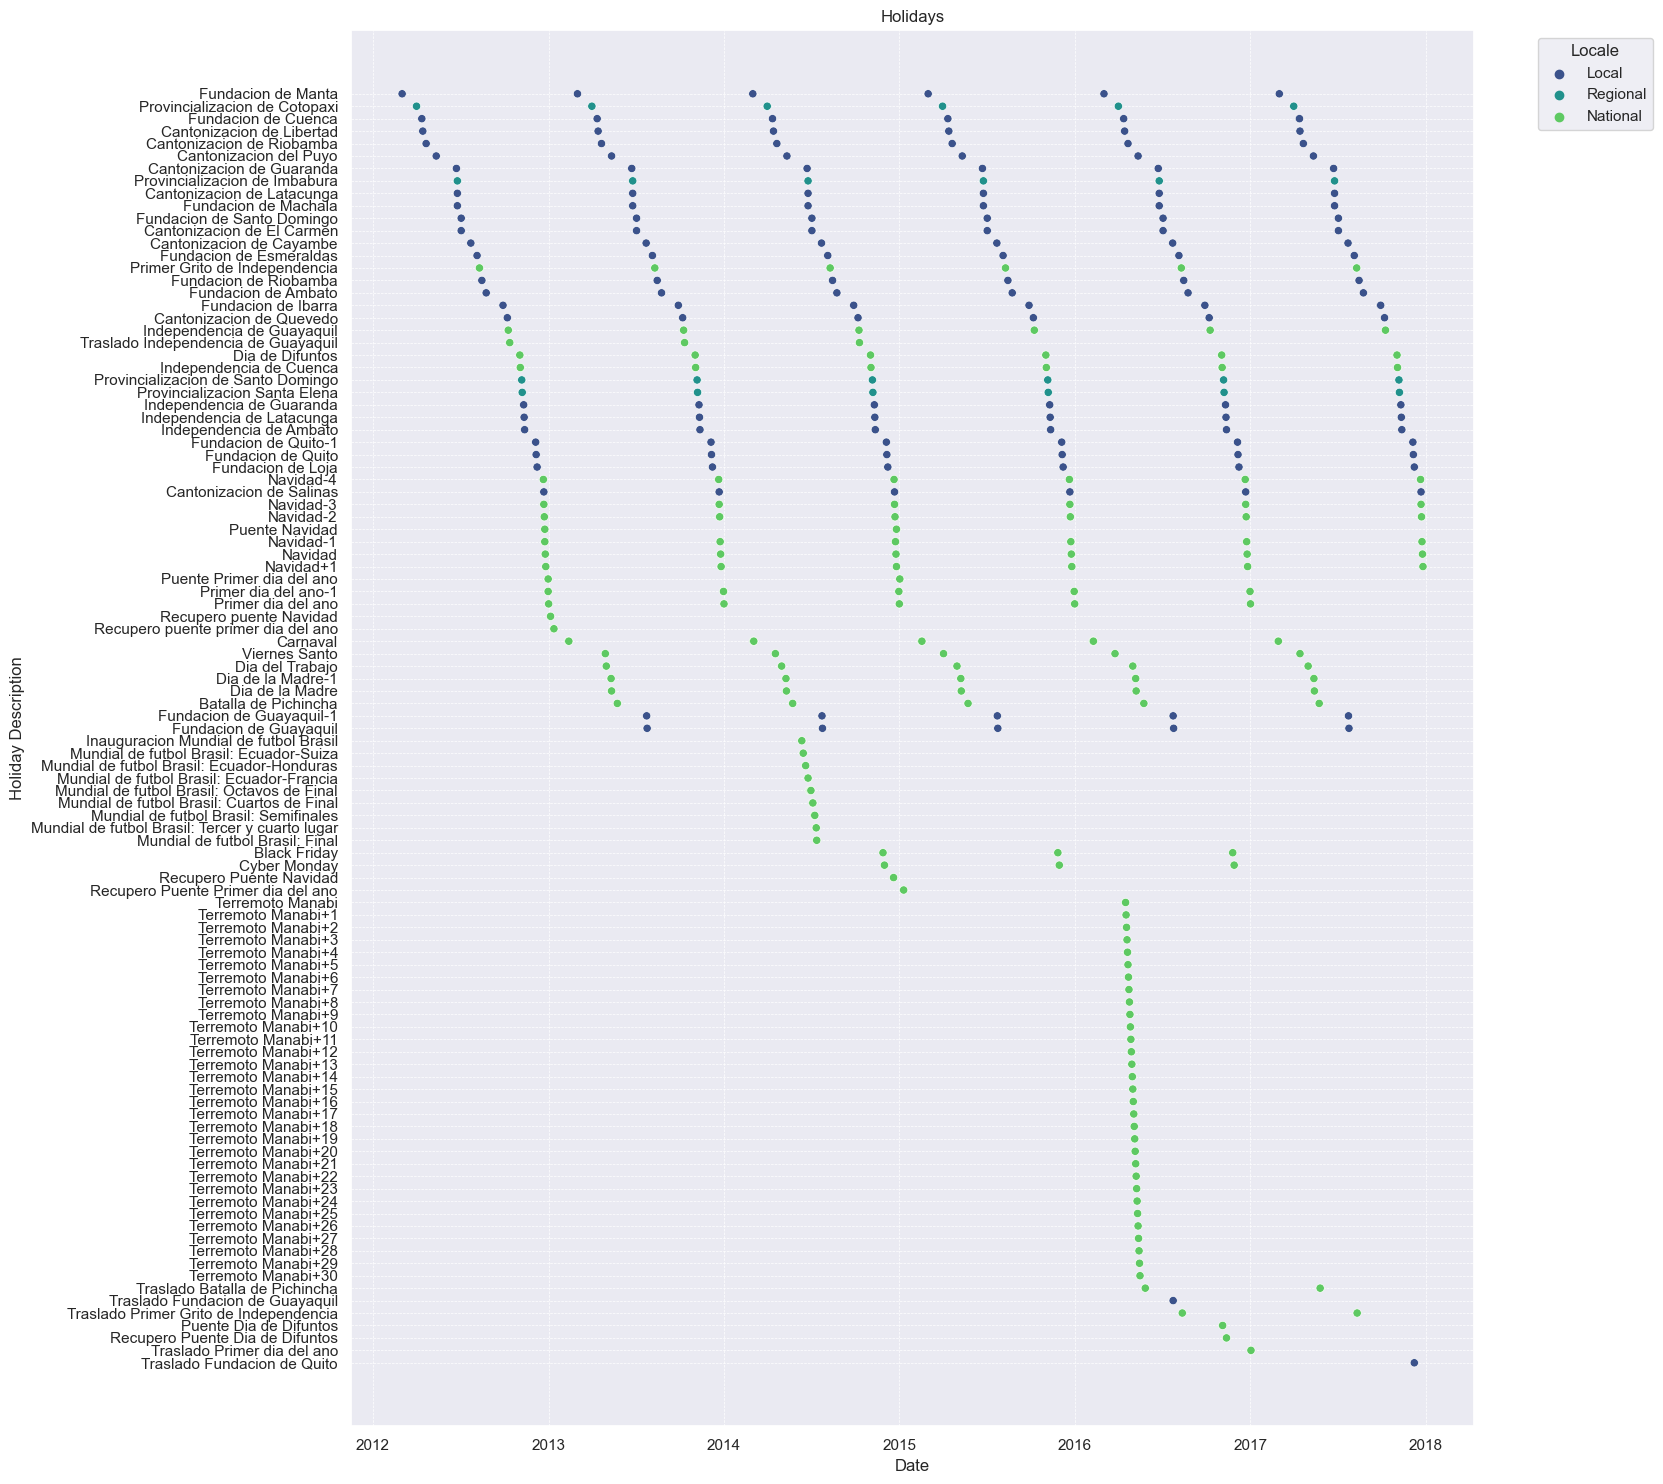

In [9]:
# Convert the date column to datetime format
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

# # Filter the data for the years 2013-2014
# holidays_2013_2014 = holidays_df[(holidays_df['date'].dt.year >= 2013) & (holidays_df['date'].dt.year <= 2014)]

# Plotting
plt.figure(figsize=(15, 15))
sns.scatterplot(data=holidays_df, x='date', y='description', hue='locale', palette='viridis', marker='o')
plt.title('Holidays')
plt.xlabel('Date')
plt.ylabel('Holiday Description')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend(title='Locale', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Stores:

In [10]:
store_df.store_nbr.nunique()

54

In [11]:
store_df.state.nunique()

16

In [12]:
store_df.city.nunique()

22

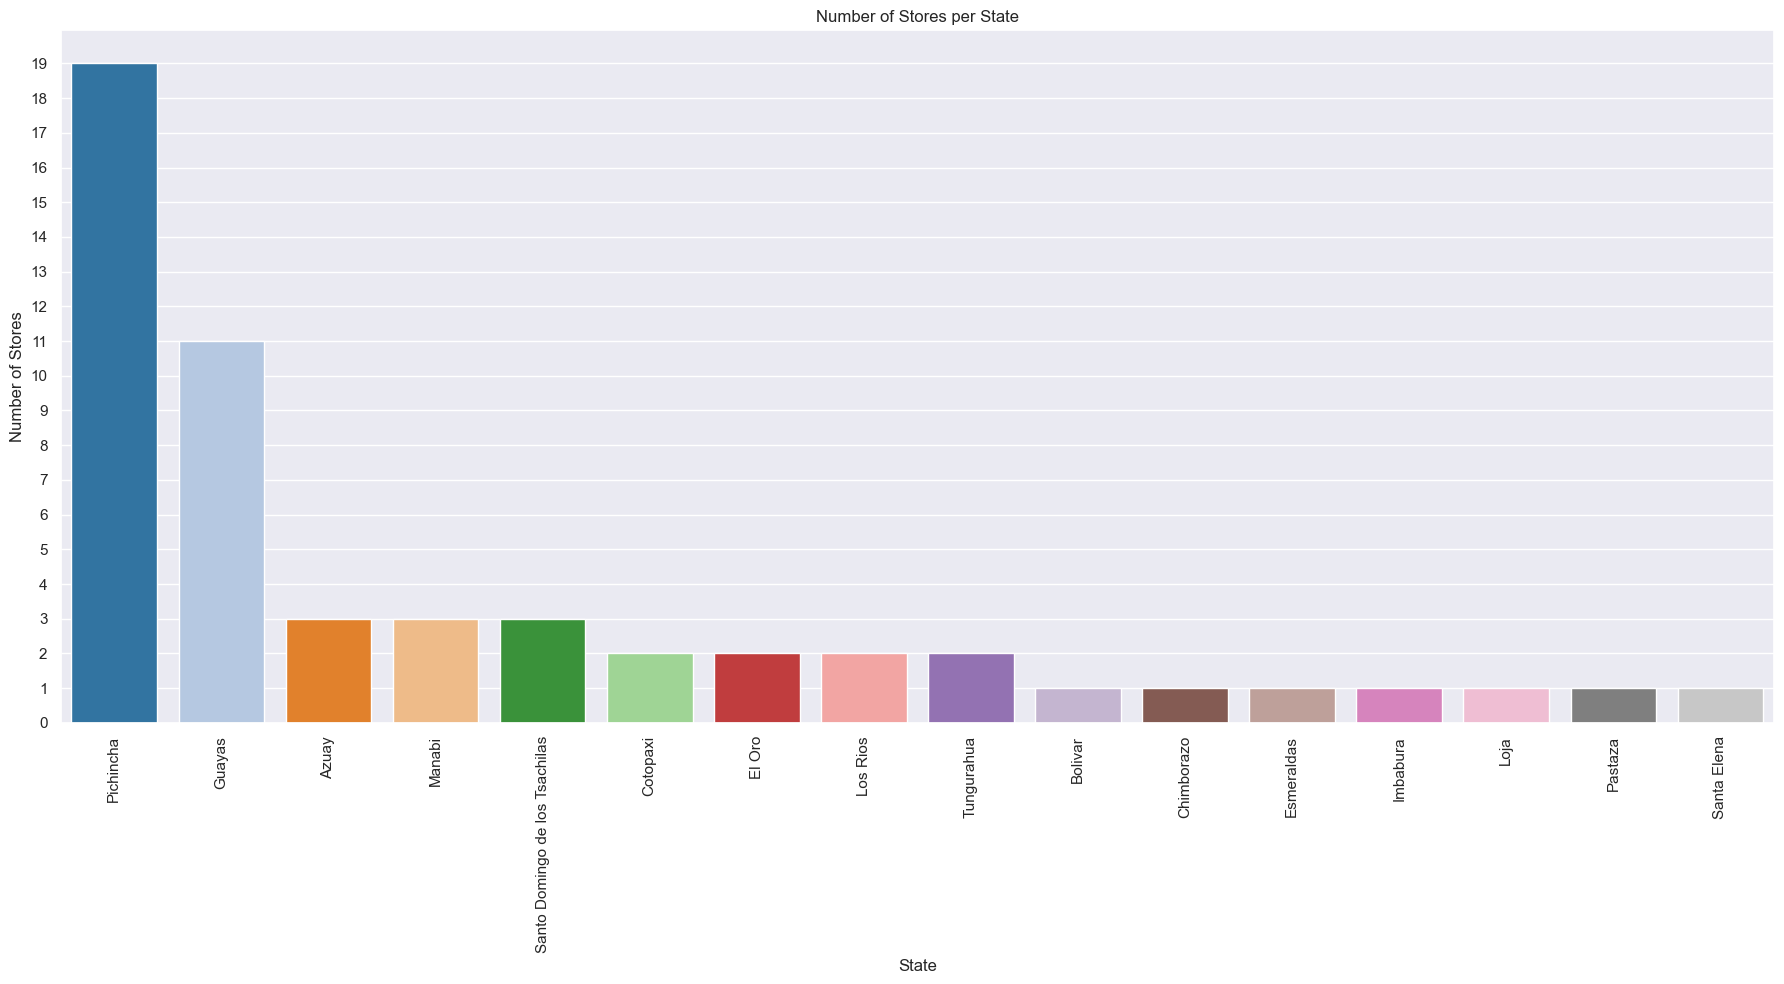

In [13]:
# Count the number of stores in each state
store_count = store_df.groupby('state').store_nbr.nunique().sort_values(ascending=False).reset_index()

# Plotting
plt.figure(figsize=(18,10))
sns.barplot(data=store_count, x='state', y='store_nbr', palette='tab20')

# Setting whole number units for y-axis
max_stores = store_count['store_nbr'].max()
plt.yticks(list(range(0, max_stores + 1)))

plt.title('Number of Stores per State')
plt.ylabel('Number of Stores')
plt.xlabel('State')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

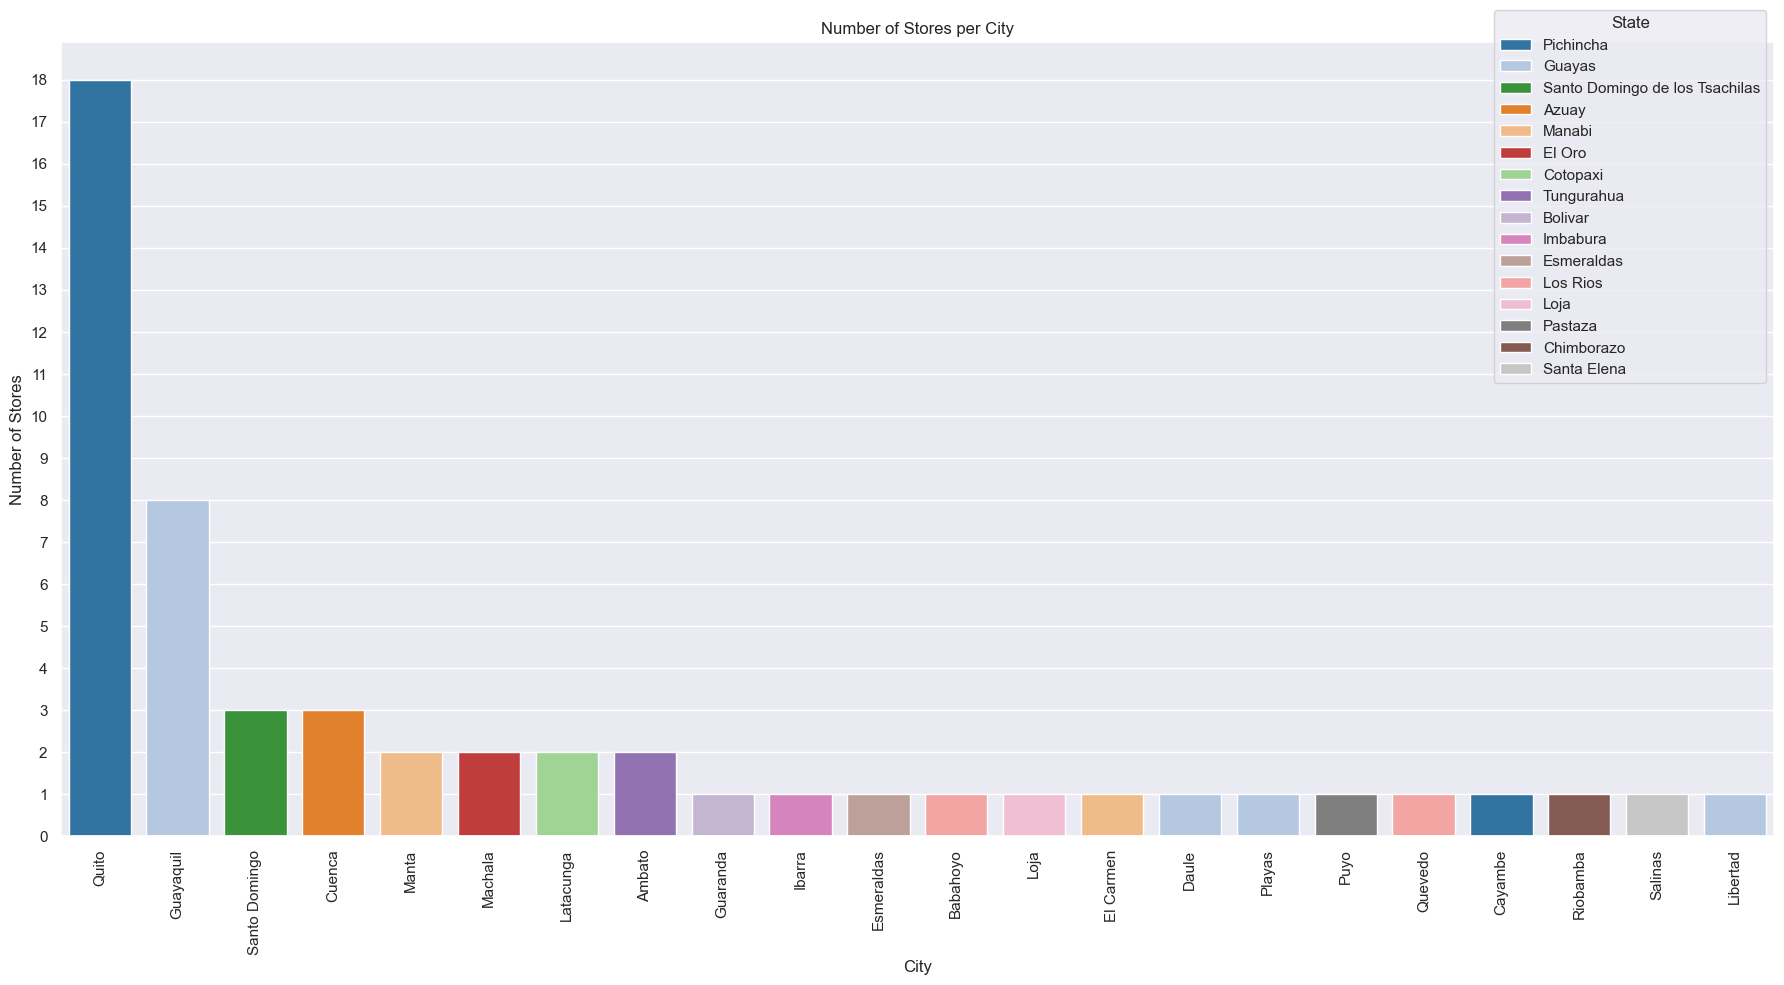

In [14]:
# Count the number of stores in each city with state as hue
store_count = store_df.groupby(['city', 'state']).store_nbr.nunique().sort_values(ascending=False).reset_index()

# Create a custom color palette to match with the state color map above
custom_palette = {
    'Pichincha': '#1f77b4',
    'Guayas': '#aec7e8',
    'Azuay': '#ff7f0e',
    'Manabi': '#ffbb78',
    'Santo Domingo de los Tsachilas': '#2ca02c',
    'Cotopaxi': '#98df8a',
    'El Oro': '#d62728',
    'Los Rios': '#ff9896',
    'Tungurahua': '#9467bd',
    'Bolivar': '#c5b0d5',
    'Chimborazo': '#8c564b',
    'Esmeraldas': '#c49c94',
    'Imbabura': '#e377c2',
    'Loja': '#f7b6d2',
    'Pastaza': '#7f7f7f',
    'Santa Elena': '#c7c7c7'
}

# Plotting
plt.figure(figsize=(18,10))
sns.barplot(data=store_count, x='city', y='store_nbr', hue='state', palette=custom_palette, dodge=False, width=0.8)

# Setting whole number units for y-axis
max_stores = store_count['store_nbr'].max()
plt.yticks(list(range(0, max_stores + 1)))

plt.title('Number of Stores per City')
plt.ylabel('Number of Stores')
plt.xlabel('City')
plt.xticks(rotation=90)

# Move legend to the top right corner
plt.legend(title='State', loc='upper right', bbox_to_anchor=(1, 1.05))

plt.tight_layout()
plt.show()


Prep on store_sales_df:

In [15]:
# The raw dataframe
store_sales_df.isnull().sum()

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion    28512
dtype: int64

In [16]:
# The raw dataframe
store_sales_df.duplicated().sum()

0

Adding features to complete dataset:

In [17]:
# Add more datetime column 
store_sales_df['year'] = store_sales_df['date'].dt.year
store_sales_df['month'] = store_sales_df['date'].dt.month
store_sales_df['week'] = store_sales_df['date'].dt.isocalendar().week.astype(int)
store_sales_df['day_name'] = store_sales_df['date'].dt.day_of_week
store_sales_df['day_name'] = store_sales_df['date'].dt.day_name()

In [18]:
store_sales_df

,id,date,store_nbr,family,sales,onpromotion,year,month,week,day_name
0,0,2013-01-01,1,AUTOMOTIVE,0.00000,0.00000,2013,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.00000,0.00000,2013,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.00000,0.00000,2013,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.00000,0.00000,2013,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.00000,0.00000,2013,1,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,1.00000,NaN,2017,8,35,Thursday
3029396,3029396,2017-08-31,9,PREPARED FOODS,0.00000,NaN,2017,8,35,Thursday
3029397,3029397,2017-08-31,9,PRODUCE,1.00000,NaN,2017,8,35,Thursday
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9.00000,NaN,2017,8,35,Thursday


In [19]:
store_sales_historical = store_sales_df[store_sales_df['date'] < '2017-01-01']
store_sales_historical

,id,date,store_nbr,family,sales,onpromotion,year,month,week,day_name
0,0,2013-01-01,1,AUTOMOTIVE,0.00000,0.00000,2013,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.00000,0.00000,2013,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.00000,0.00000,2013,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.00000,0.00000,2013,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.00000,0.00000,2013,1,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...
2596369,2596369,2016-12-31,9,POULTRY,687.85300,1.00000,2016,12,52,Saturday
2596370,2596370,2016-12-31,9,PREPARED FOODS,100.40500,1.00000,2016,12,52,Saturday
2596371,2596371,2016-12-31,9,PRODUCE,3091.35600,3.00000,2016,12,52,Saturday
2596372,2596372,2016-12-31,9,SCHOOL AND OFFICE SUPPLIES,2.00000,0.00000,2016,12,52,Saturday


In [20]:
store_sales_validation = store_sales_df[store_sales_df['date'] >= '2017-01-01']
store_sales_validation

,id,date,store_nbr,family,sales,onpromotion,year,month,week,day_name
2596374,2596374,2017-01-01,1,AUTOMOTIVE,0.00000,0.00000,2017,1,52,Sunday
2596375,2596375,2017-01-01,1,BABY CARE,0.00000,0.00000,2017,1,52,Sunday
2596376,2596376,2017-01-01,1,BEAUTY,0.00000,0.00000,2017,1,52,Sunday
2596377,2596377,2017-01-01,1,BEVERAGES,0.00000,0.00000,2017,1,52,Sunday
2596378,2596378,2017-01-01,1,BOOKS,0.00000,0.00000,2017,1,52,Sunday
...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,1.00000,NaN,2017,8,35,Thursday
3029396,3029396,2017-08-31,9,PREPARED FOODS,0.00000,NaN,2017,8,35,Thursday
3029397,3029397,2017-08-31,9,PRODUCE,1.00000,NaN,2017,8,35,Thursday
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9.00000,NaN,2017,8,35,Thursday


EDA:

Plot per sale for all historical data:

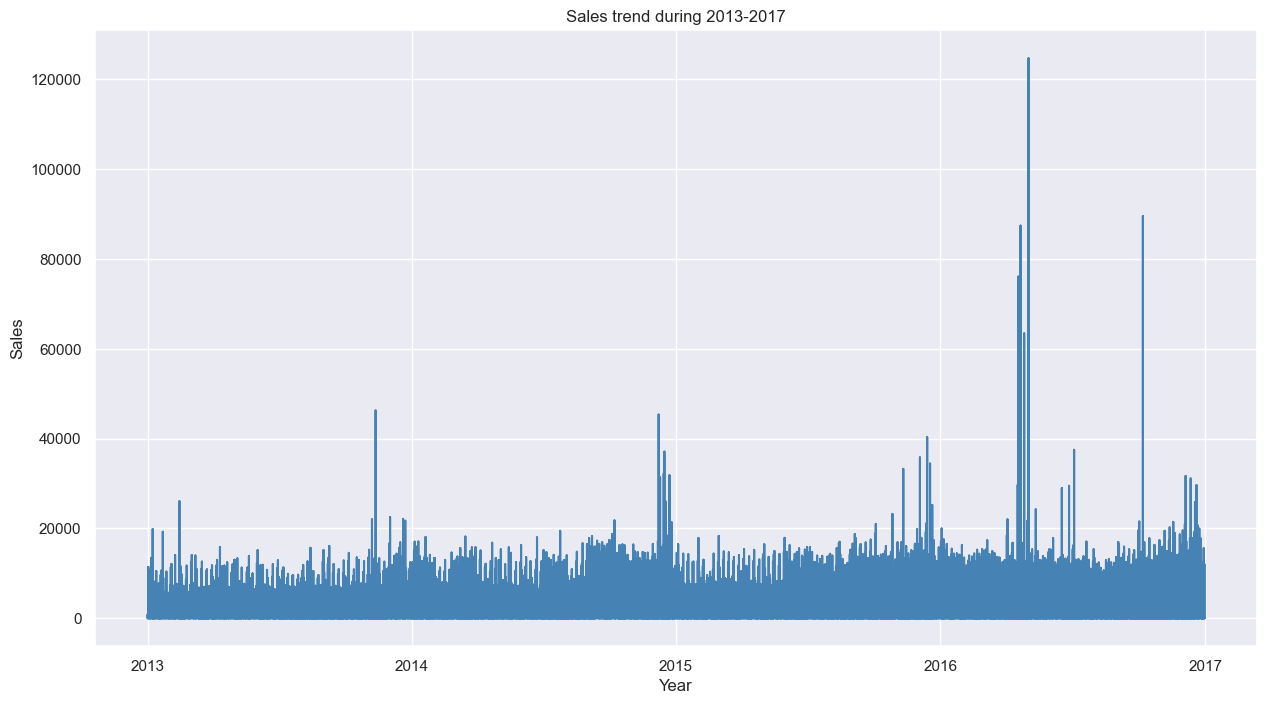

In [21]:
# 
import matplotlib.dates as mdates

plt.figure(figsize=(15,8))
plt.plot(store_sales_historical.date, store_sales_historical.sales, color='steelblue')

# Setting the x-axis scale to be in year units
years = mdates.YearLocator()   # Every year
years_fmt = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.title('Sales trend during 2013-2017')
plt.ylabel('Sales')
plt.xlabel('Year')

plt.show()

* Time Span: The graph covers a time span from 2013 to 2017. Data from 2013-01-01 to 2017-08-15. 2017 data only covers until 15th of August (only half of the month).
* Overall Trend: The data seems to display a relatively stable trend of sales with periodic spikes. The frequency of these spikes suggests some form of cyclical or seasonal trend.
* Peaks: There are significant peaks in the end part of the year, from the 2013 - 2017 data.
* Fluctuations: The year of 2016 have much more pronounced fluctuations of sales compared to other, which suggests a volatility during those years probably impacted by the external environment. The cause might be a magnitude 7.8 earthquake struck Ecuador on April 16, 2016. "People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake" ([Source](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)). If we compare the sales with the Holiday & Events calendar, there's an unprecedented national event windows called "Terremoto Manabi" that extended to "Terremoto Manabi +30" for 30 days.

Overall sales trend by date:

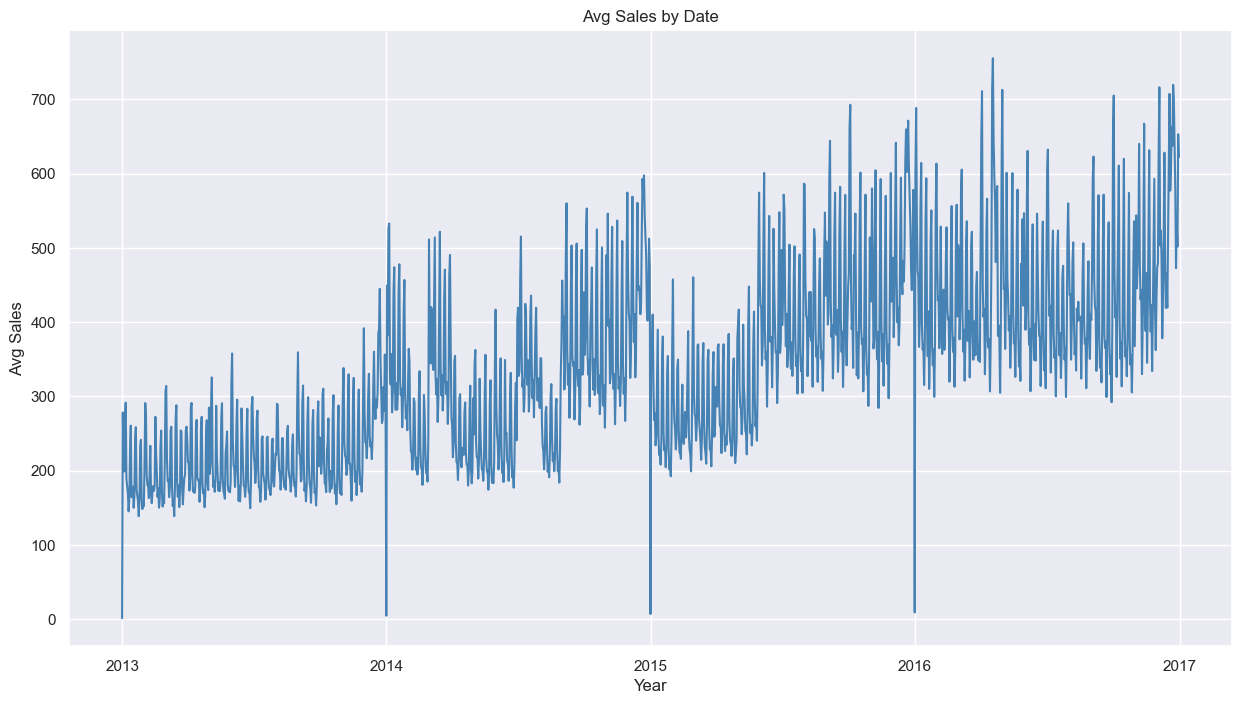

In [22]:
# Aggregate sales by date
date_sales = store_sales_historical.groupby('date')['sales'].mean().reset_index()

plt.figure(figsize=(15,8))
plt.plot(date_sales.date, date_sales.sales, color='steelblue')
plt.ticklabel_format(style='plain', axis='y')
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.title('Avg Sales by Date')
plt.ylabel('Avg Sales')
plt.xlabel('Year')
plt.show()

* Fluctuations: The historical sales data exhibits periodic spikes, suggesting possible seasonal influences or promotional events that lead to peaks in sales. Starting from 2014 towards 2017, there is a noticeable increase in the frequency and height of the spikes. This could indicate growing customer interest, more successful marketing campaigns, or the expansion of the business.
* Overall trend: The sales figures from 2013 to 2017 show an upward trend. The baseline (lowest points between the peaks) also appears to be increasing over time, indicating a steady growth in sales.
* 2015: There's a noticeable change in the year 2015 where the sales figures seem to become denser with more frequent fluctuations.
* 2016: Towards the end of the chart, in 2017, there is a clear upward trend with sales figures consistently staying on the higher side. The impact of the Terremoto de Ecuador de 2016 earthquake might have impacted this trend starting from April 2016.

Sales by Year:

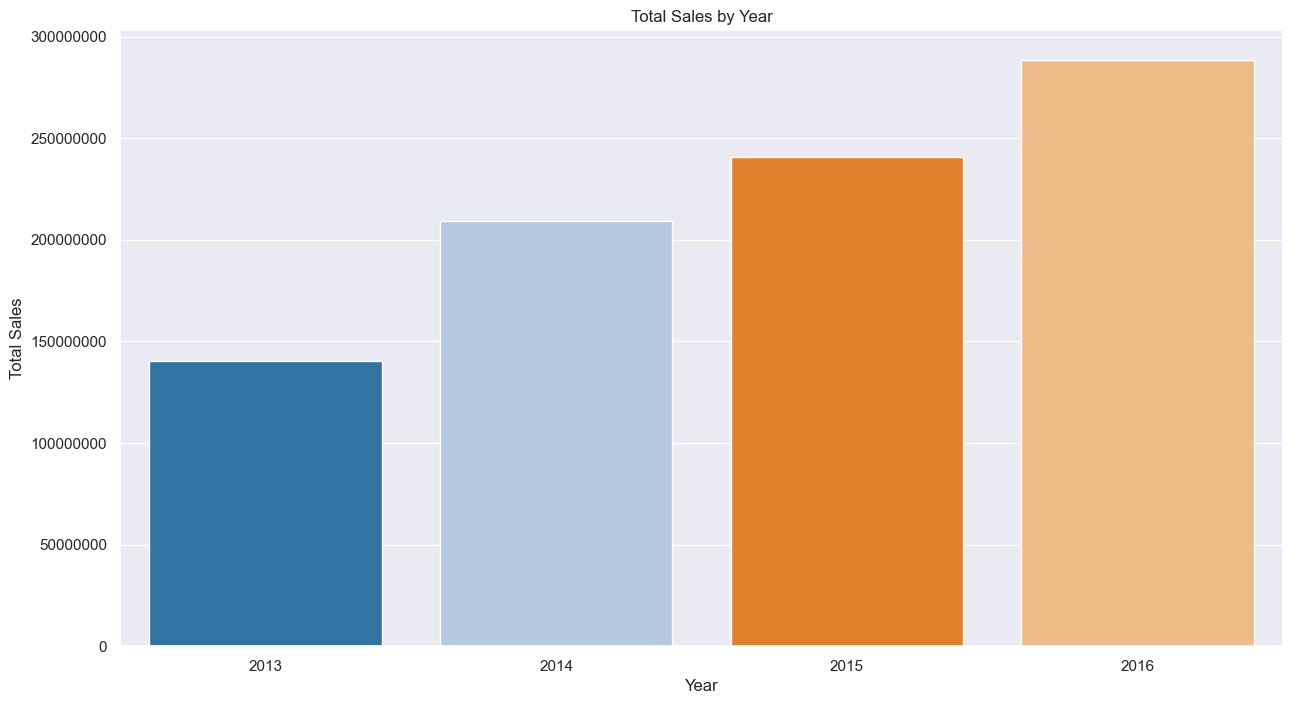

In [23]:
# Aggregate sales by year
yearly_sales = store_sales_historical.groupby('year')['sales'].sum().reset_index()

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(data=yearly_sales, x='year', y='sales', palette='tab20')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Total Sales by Year')
plt.ylabel('Total Sales')
plt.xlabel('Year')
plt.show()

There's a consistent growth in total sales from 2013 to 2016. Each year experienced higher sales than the previous year.

Sales by Month:

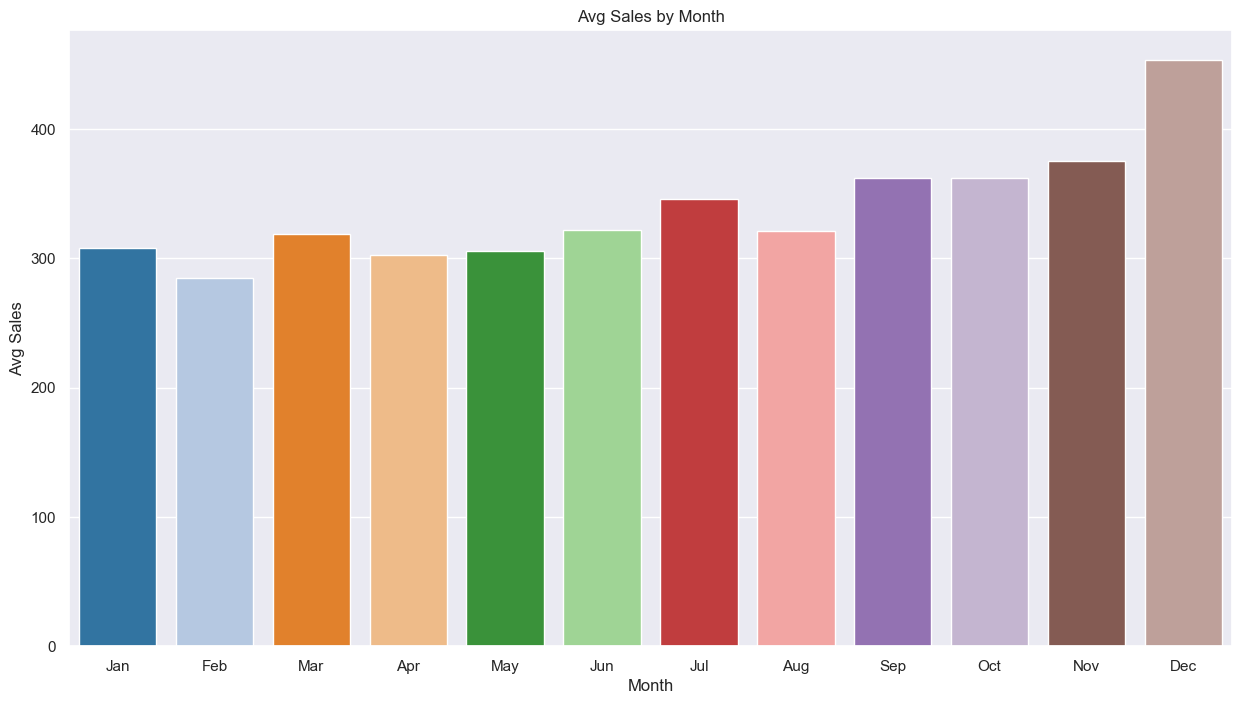

In [24]:
# Averge sales by month
monthly_sales = store_sales_historical.groupby('month')['sales'].mean().reset_index()

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(data=monthly_sales, x='month', y='sales', palette='tab20')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Avg Sales by Month')
plt.ylabel('Avg Sales')
plt.xlabel('Month')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

The months with the lowest average sales are February and September. Sales then begin to rise again in the last quarter of the year, from September, October to December.

Sales by Day of the Week:

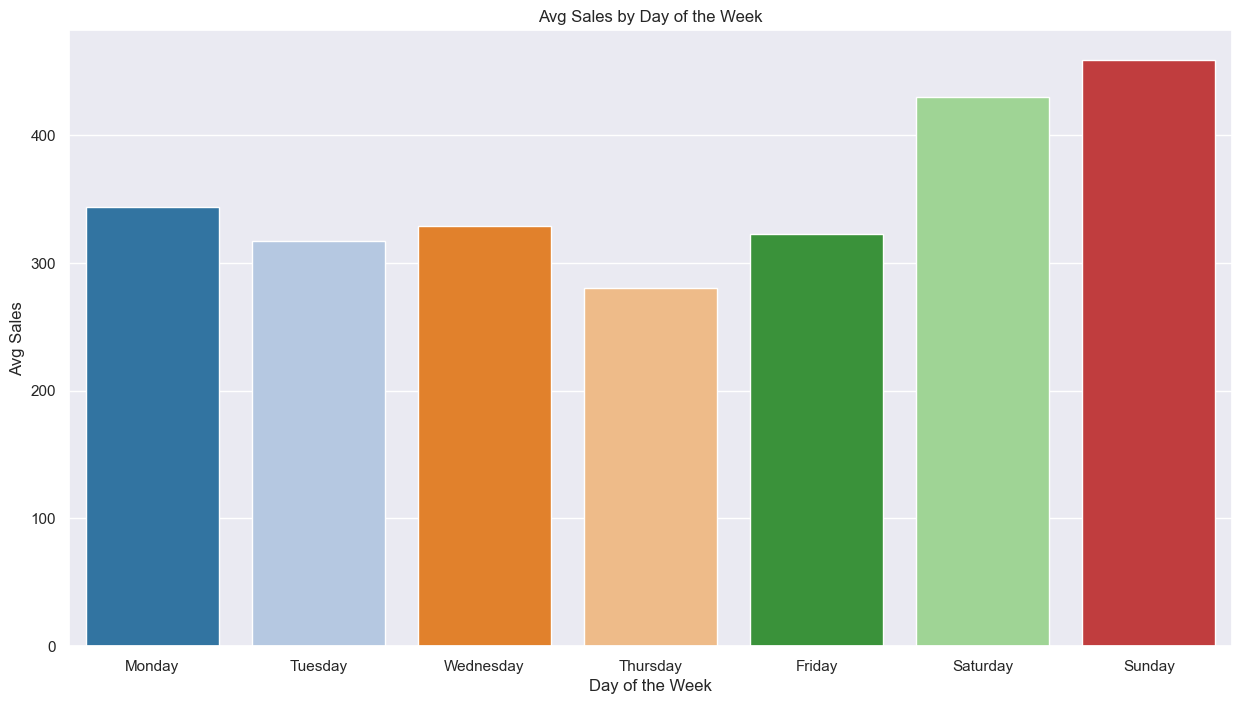

In [25]:
# Create a list of days in order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Average sales by day of the week
daily_sales = store_sales_df.groupby('day_name')['sales'].mean().reindex(days_order).reset_index()

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(data=daily_sales, x='day_name', y='sales', order=days_order, palette='tab20')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Avg Sales by Day of the Week')
plt.ylabel('Avg Sales')
plt.xlabel('Day of the Week')
plt.show()

There's a noticeable trend in the average sales throughout the week. Sales start relatively lower on Monday through Wednesday, see a dip on Thursday, and starting to pick up from Friday through Sunday. Weekends such as Saturday and Sunday are the most popular shopping day.

In [26]:
store_sales_historical

,id,date,store_nbr,family,sales,onpromotion,year,month,week,day_name
0,0,2013-01-01,1,AUTOMOTIVE,0.00000,0.00000,2013,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.00000,0.00000,2013,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.00000,0.00000,2013,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.00000,0.00000,2013,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.00000,0.00000,2013,1,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...
2596369,2596369,2016-12-31,9,POULTRY,687.85300,1.00000,2016,12,52,Saturday
2596370,2596370,2016-12-31,9,PREPARED FOODS,100.40500,1.00000,2016,12,52,Saturday
2596371,2596371,2016-12-31,9,PRODUCE,3091.35600,3.00000,2016,12,52,Saturday
2596372,2596372,2016-12-31,9,SCHOOL AND OFFICE SUPPLIES,2.00000,0.00000,2016,12,52,Saturday


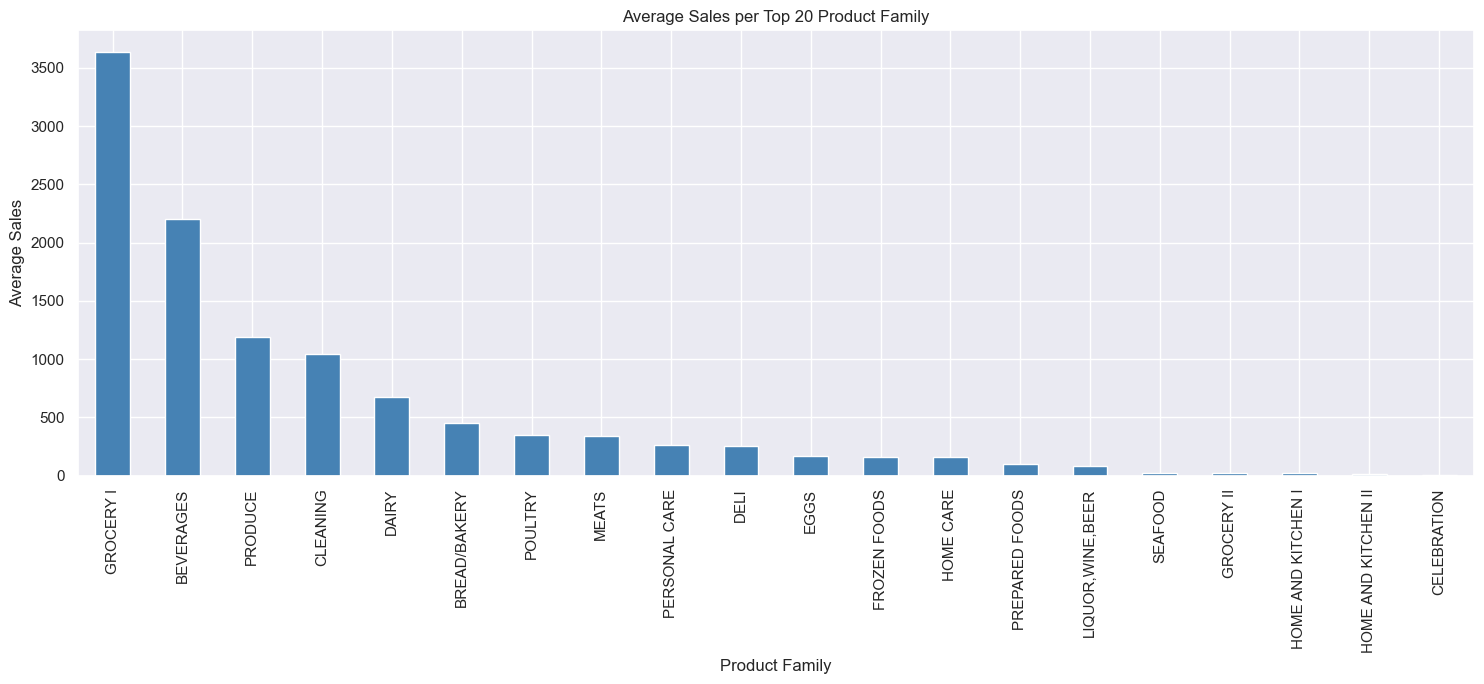

In [27]:
# Group by 'family' and calculate the average sales
avg_sales = store_sales_historical.groupby('family')['sales'].mean().sort_values(ascending=False)

# Take the top 20 product families
top_20_families = avg_sales.head(20)

# Plotting
plt.figure(figsize=(15, 7))
top_20_families.plot(kind='bar', color='steelblue')
plt.title('Average Sales per Top 20 Product Family')
plt.ylabel('Average Sales')
plt.xlabel('Product Family')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

* The 'GROCERY I' product family has the highest average sales by a significant margin, second by 'BEVERAGES' which combined exceeding all other product families by a big distance. . The top 5 product families by average sales are 'GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING', and 'DAIRY'.
* 'BREAD/BAKERY', 'POULTRY', 'MEATS', 'PERSONAL CARE', 'DELI', 'EGGS', 'FROZEN FOODS', 'HOME CARE', 'PREPARED FOODS', 'LIQUOR,WINE,BEER' belong to the low to moderate group of product family sales. There's a noticeable drop for the rest of the product families after the top 15.
* The top 20 product families cover a broad range of consumer goods, from grocery ('GROCERY I', 'GROCERY II'), essential food item (like 'DAIRY', 'POULTRY', 'EGGS'), beverages, meat, produce & frozen food, cleaning, health & beauty care to more niche categories ('CELEBRATION', 'HOME AND KITCHEN').

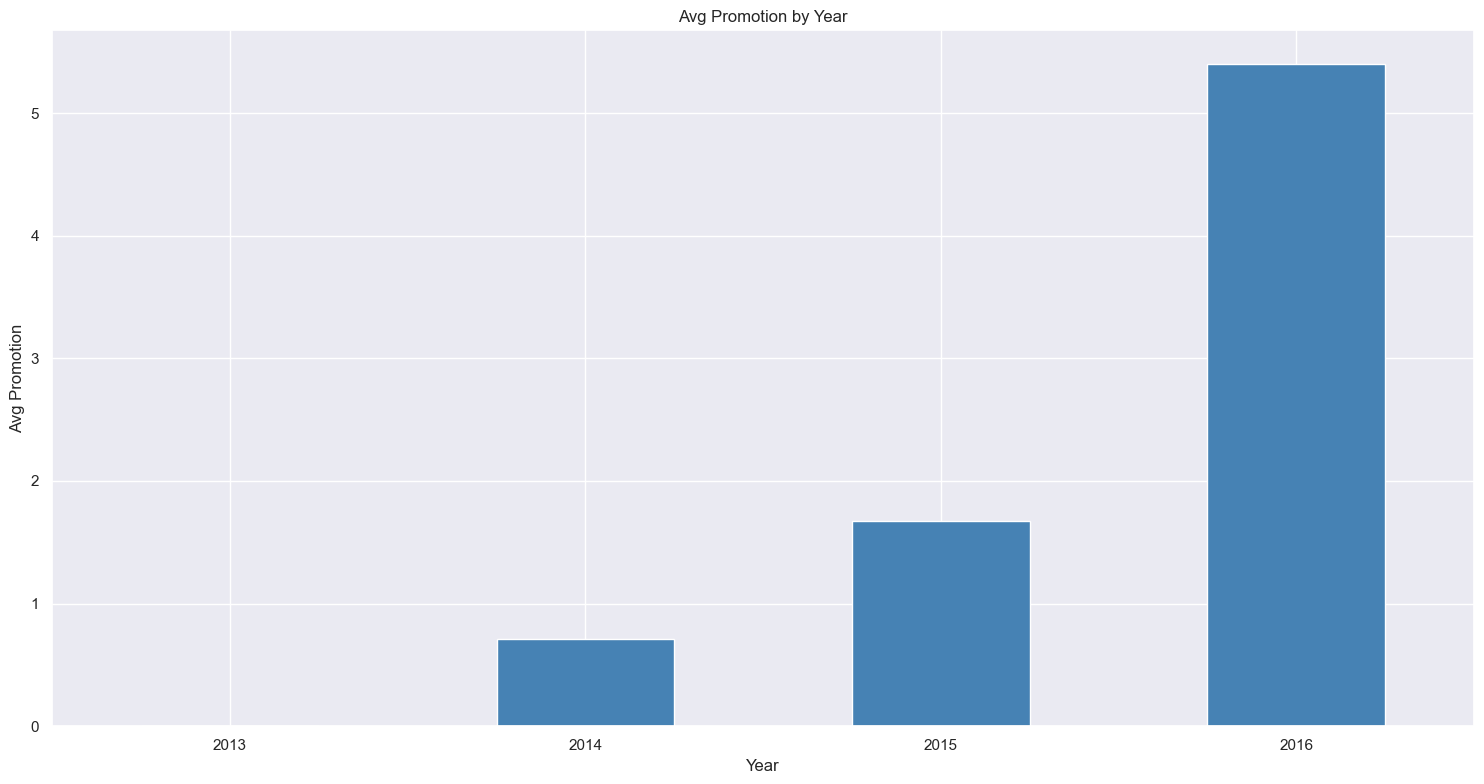

In [28]:
# Group by 'year' and sum the 'onpromotion' column
yearly_promotions = store_sales_historical.groupby('year')['onpromotion'].mean()

# Plotting
plt.figure(figsize=(15,8))
yearly_promotions.plot(kind='bar', color='steelblue')
plt.title('Avg Promotion by Year')
plt.xlabel('Year')
plt.ylabel('Avg Promotion')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

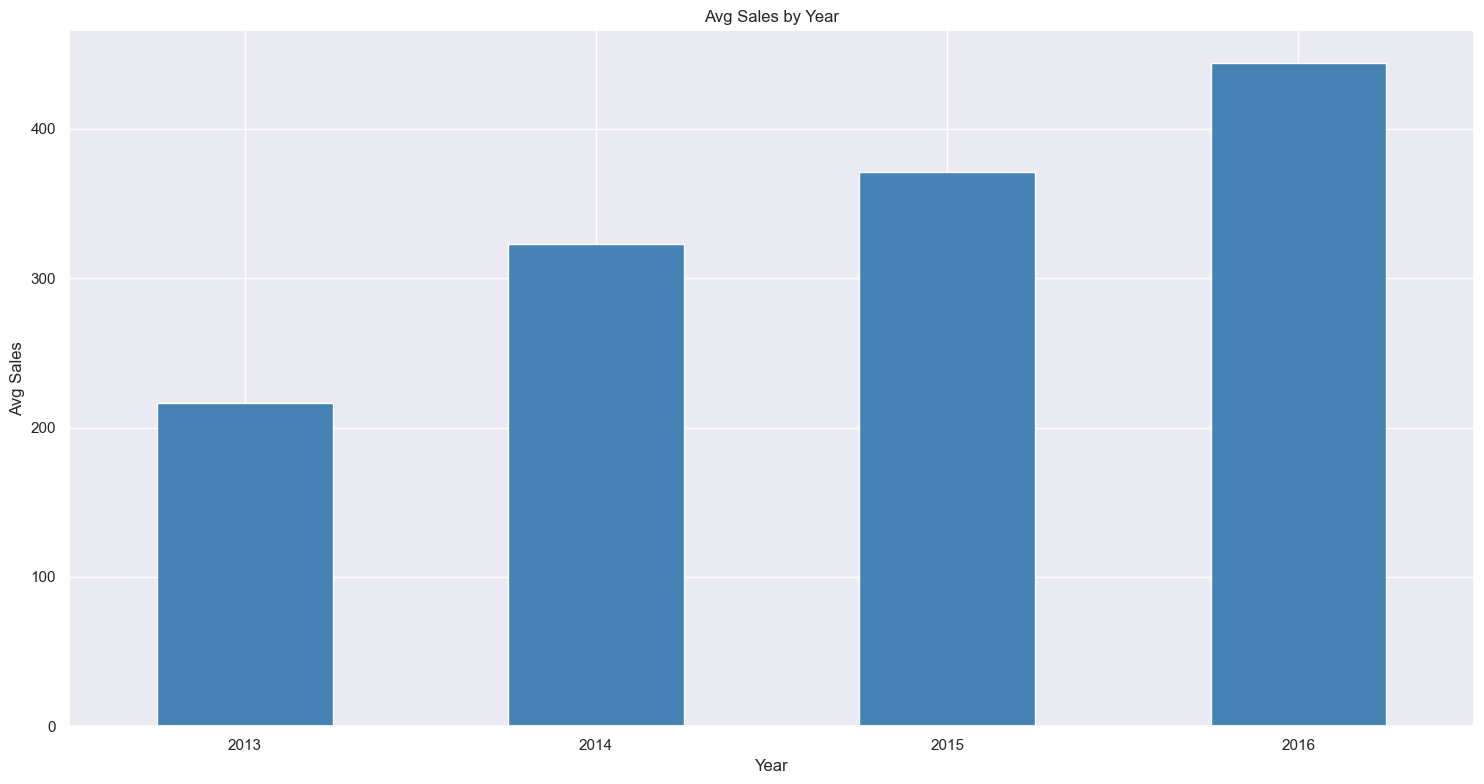

In [29]:
# Group by 'year' and average the 'sales' column
yearly_sales = store_sales_historical.groupby('year')['sales'].mean()

# Plotting
plt.figure(figsize=(15,8))
yearly_sales.plot(kind='bar', color='steelblue')
plt.title('Avg Sales by Year')
plt.xlabel('Year')
plt.ylabel('Avg Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Comparing Avg. Promotion vs. Avg. Sales per year:

* Promotions Trend: 2013 saw a minimal average promotion, almost close to zero, while there's a slight increase in promotions in 2014 but was still relatively low. The average number of promotions quickly increase from 2015 to 2016.
* Sales Trend: In 2013, the average sales were just above 200 almost without any promotion. The average sales increased by nearly one-third in 2014, approaching the 300 mark with around 1 promo on average per year. Although there are nearly 2 promotions on average per year in 2015, the year 2015 experienced a slower growth compared to 2014. The average number of promotions skyrocketed to almost 5 per year in 2016, whereas the highest average sales were also recorded in 2016, surpassing 400. 
* The rise in average sales from 2013 to 2014 might correspond to promotions, but can also indicates that other factors not captured in our charts.
* 2016 had both the highest promotions and sales, which overlaps with the earthquake event in 2016. The promotional strategy and external factors benefiting the business sales that year don't necessarily indicate positive impacts on profits. The grocery chain might receive funding from the government or investing more on CSR after the dreaded event. We'll investigate about that right after with the comparison between the average promotion and sales per month of each year.

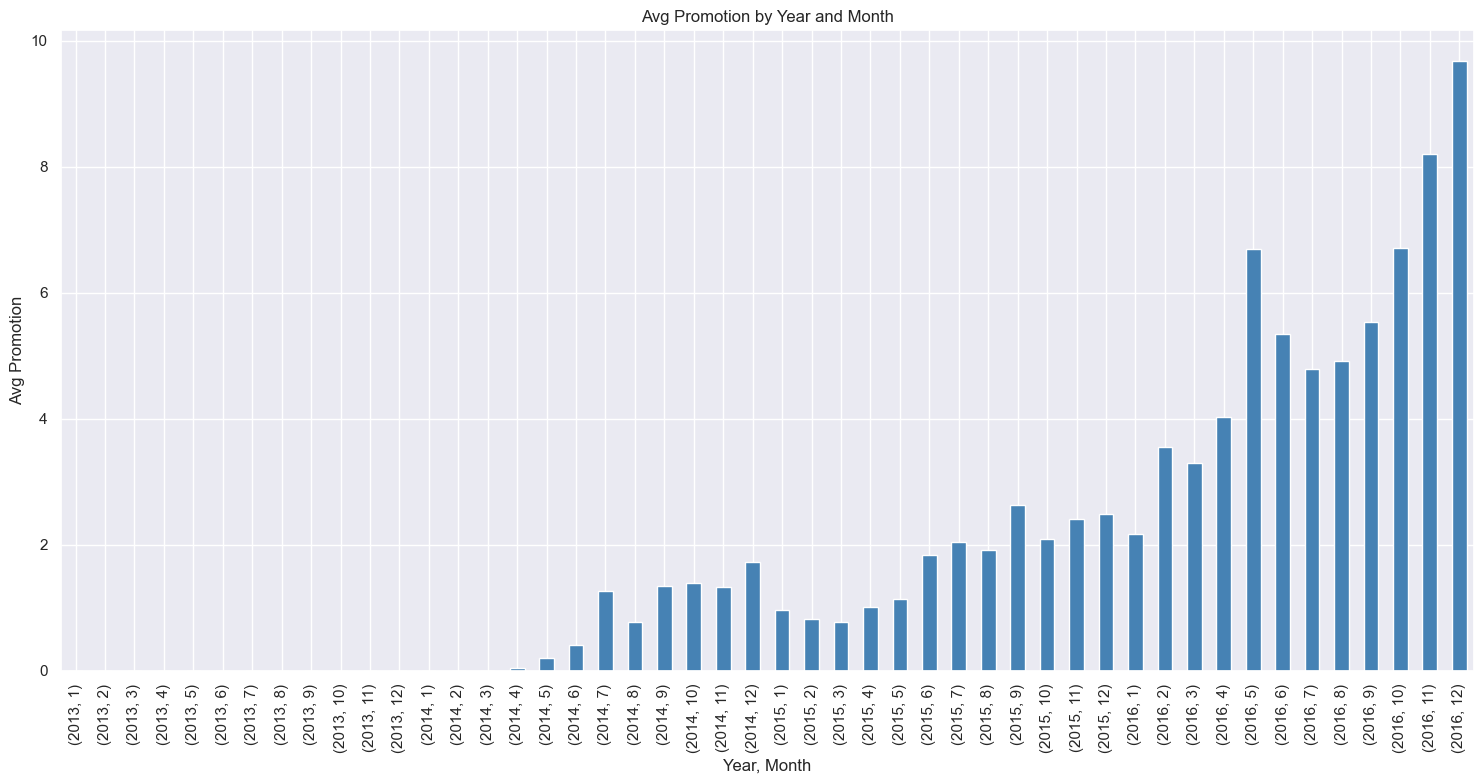

In [30]:
# Group by 'year' and 'month' and then compute the mean of the 'onpromotion' column
year_month_promotions = store_sales_historical.groupby(['year', 'month'])['onpromotion'].mean()

# Plotting
plt.figure(figsize=(15,8))
year_month_promotions.plot(kind='bar', color='steelblue')
plt.title('Avg Promotion by Year and Month')
plt.xlabel('Year, Month')
plt.ylabel('Avg Promotion')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


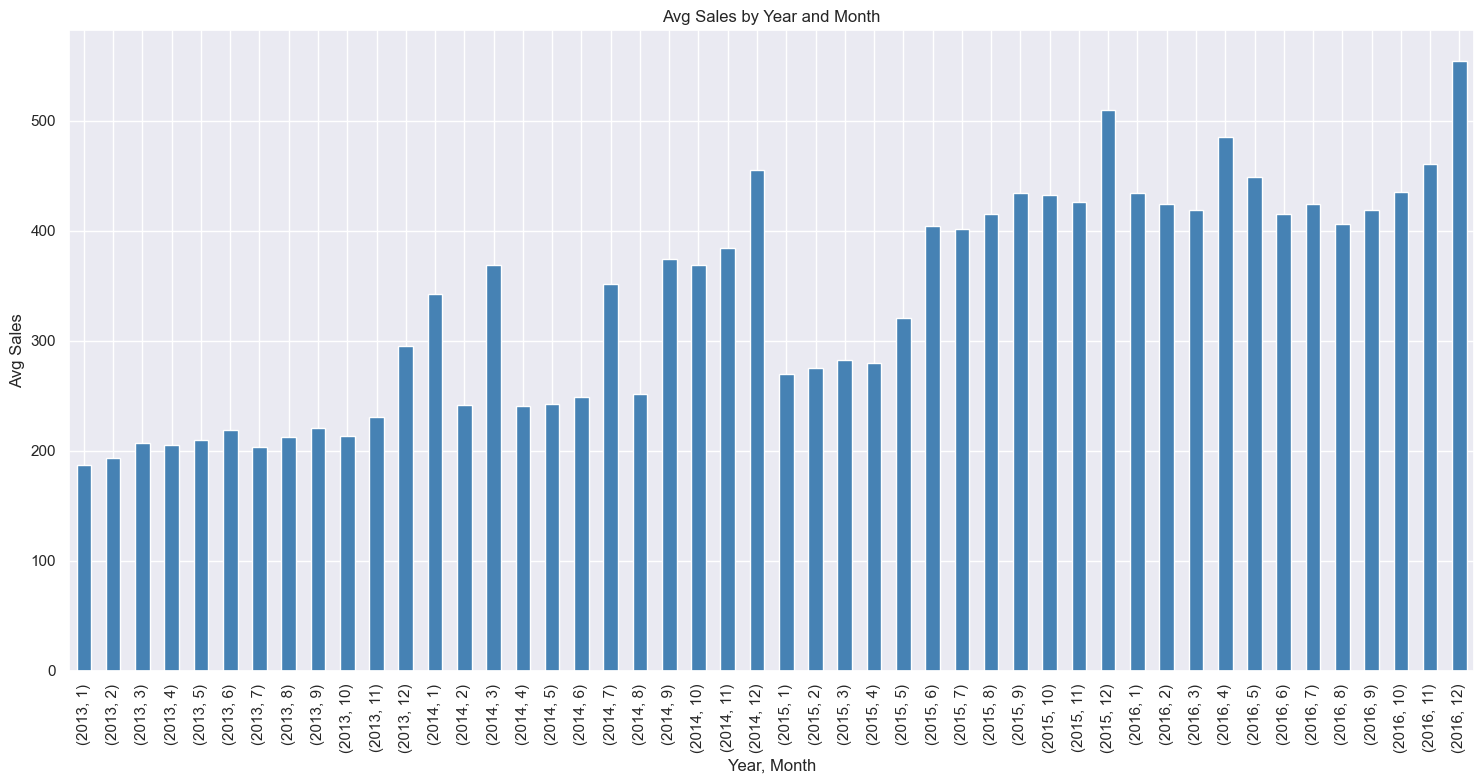

In [31]:
# Group by 'year' and 'month' and then compute the mean of the 'sales' column
year_month_sales = store_sales_historical.groupby(['year', 'month'])['sales'].mean()

# Plotting
plt.figure(figsize=(15,8))
year_month_sales.plot(kind='bar', color='steelblue')
plt.title('Avg Sales by Year and Month')
plt.xlabel('Year, Month')
plt.ylabel('Avg Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Comparing Avg. Promotion vs. Avg. Sales per month of the year:

* Avg Promotion by Year and Month: The average promotion remained relatively low from the beginning of 2013 up to mid-2015. Starting from late 2015, there's a noticeable upward trend in the average promotion, with the values increasing steadily. There is a clear trend of the business focusing on upping the average number of promotions from September to December every year. It's the period where the demand for buying grocery increase vastly with Christmas and New Year, which could also be attributed to holiday promotions or year-end sales drives.
* Avg Sales by Year and Month: There seems to correlation between promotions and sales, especially in 2014 and 2016. There's no clear trend in 2015, with some peaks and troughs but not much linked to promotion. That could come from other external factors.

In [32]:
# # Group by week and get the mean of sales
# weekly_sales = store_sales_historical.groupby(store_sales_historical['week']).agg({'sales':'mean'}).reset_index()
# weekly_sales.columns = ['week', 'sales']

# # Group by month and get the mean of sales
# monthly_sales = store_sales_historical.groupby(store_sales_historical['month']).agg({'sales':'mean'}).reset_index()
# monthly_sales.columns = ['month', 'sales']

# # Plotting
# fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# # Weekly Sales
# sns.scatterplot(x='week', y='sales', data=weekly_sales, ax=axes[0], linestyle='-', marker='o')
# sns.regplot(x='week', y='sales', data=weekly_sales, ax=axes[0])
# axes[0].set_title('Avg Sales (grouped by week)')
# axes[0].set_xlabel('week')
# axes[0].set_ylabel('sales')
# axes[0].set_xticks(range(1, 54))  # Set x-ticks to display each week from 1 to 53
# axes[0].ticklabel_format(style='plain', axis='y')
# axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# # Monthly Sales
# sns.scatterplot(x='month', y='sales', data=monthly_sales, ax=axes[1], linestyle='-', marker='o')
# sns.regplot(x='month', y='sales', data=monthly_sales, ax=axes[1])
# axes[1].set_title('Avg Sales (grouped by month)')
# axes[1].set_xlabel('month')
# axes[1].set_ylabel('sales')
# axes[1].set_xticks(range(1, 13))  # Set x-ticks to display each unique month
# axes[1].ticklabel_format(style='plain', axis='y')
# axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# plt.tight_layout()
# plt.show()

In [33]:
# date_sales object created above
date_sales2 = store_sales_historical.groupby(['date'])['sales'].agg(['sum']).reset_index().rename(columns={'sum': 'sales'})
date_sales2.set_index('date', inplace=True)
date_sales2

,sales
date,
2013-01-01,2511.61900
2013-01-02,496092.41794
2013-01-03,361461.23112
2013-01-04,354459.67709
2013-01-05,477350.12123
...,...
2016-12-27,842475.49012
2016-12-28,951533.71385
2016-12-29,894108.23683


# We'll choose to predict by month???


The line of code y = tseries['Sales'].resample('MS').mean() performs the following actions:

tseries['Sales']: This selects the 'Sales' column from the tseries dataframe.

.resample('MS'): This resamples the time series data based on a specific frequency. The 'MS' frequency string stands for "Month Start". When you resample data with this frequency, it means you're grouping the data into intervals that start on the first day of each month.

.mean(): After resampling the data into monthly intervals, this calculates the mean (average) of the 'Sales' values within each of those monthly intervals.

The result, y, is a pandas Series where the index consists of the first day of each month and the values are the average 'Sales' for each of those months.

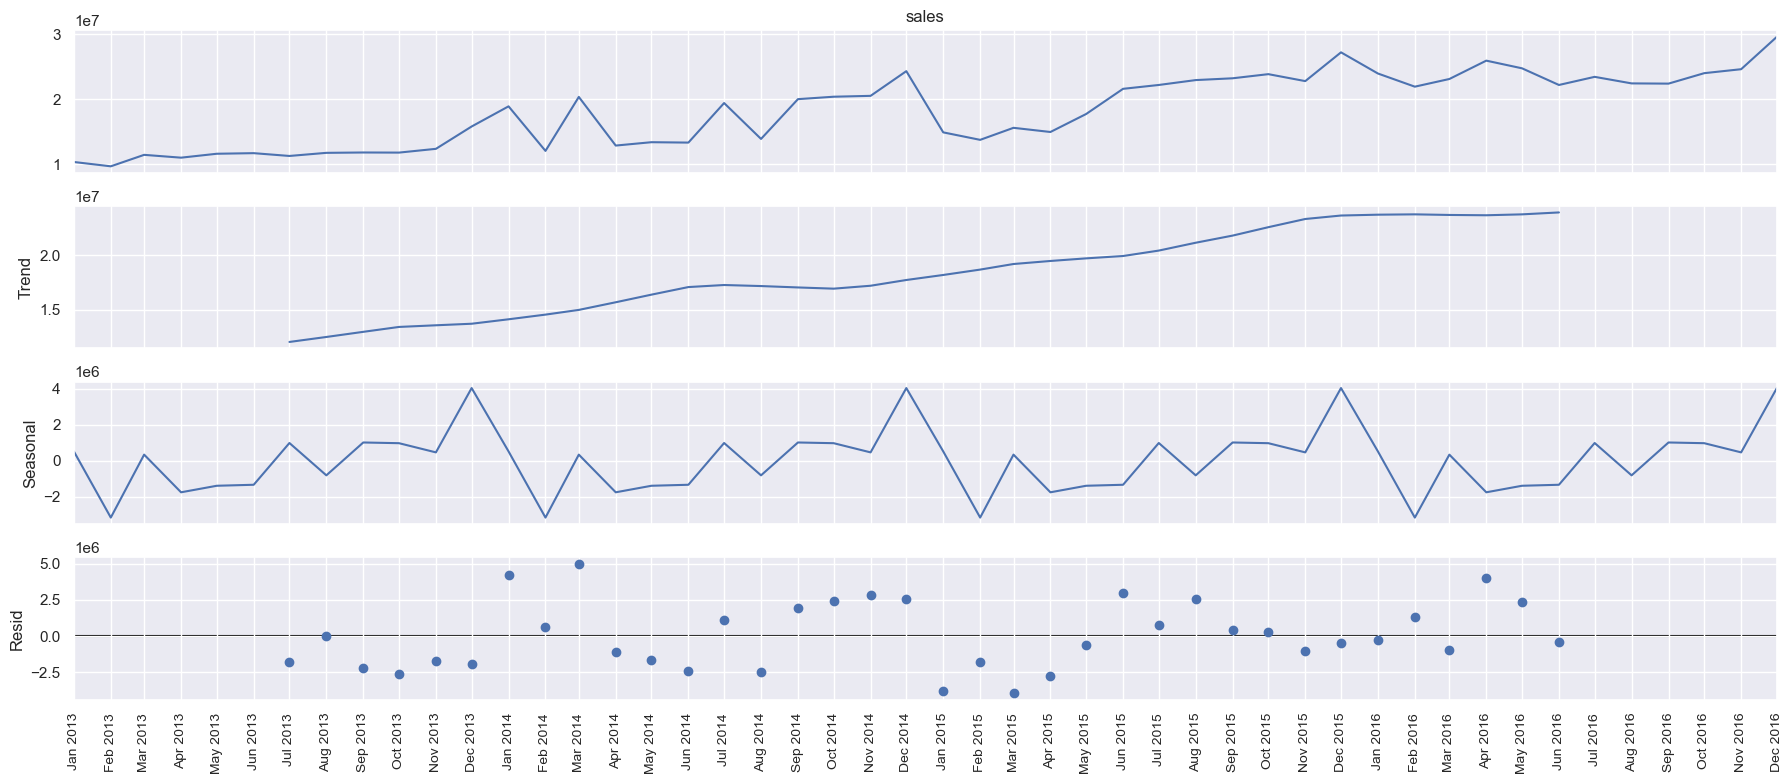

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

# Extracting sales as a time series
# y = date_sales2['sales'].resample('MS').mean()
y = date_sales2['sales'].resample('MS').sum()

# Setting the figure size
rcParams['figure.figsize'] = 18, 8

# Decomposing the time series
decomposition = seasonal_decompose(y, model='additive')

# Plotting the decomposition
fig = decomposition.plot()

# Generate a list of all months from 2013 to end of 2016
all_months = pd.date_range(start='2013-01-01', end='2016-12-31', freq='MS')

# Set these dates as x-ticks and format the x-tick labels to show month and year
plt.xticks(all_months, all_months.strftime('%b %Y'), rotation=90, fontsize=10)

plt.tight_layout()  # Adjust the layout for better appearance
plt.show()

There's an increasing trend in sales from 2013 to 2016.
Clear annual seasonality exists, with certain months consistently showing higher or lower sales.
Some unusual residuals are observed which might need further investigation to identify possible anomalies or events influencing sales in those months.

# differencing technique for transdformin non stationary to stationary

# check for stationarity

In [35]:
store_sales_historical_grouped = store_sales_historical.groupby('date')['sales'].sum().reset_index()
store_sales_historical_grouped

,date,sales
0,2013-01-01,2511.61900
1,2013-01-02,496092.41794
2,2013-01-03,361461.23112
3,2013-01-04,354459.67709
4,2013-01-05,477350.12123
...,...,...
1452,2016-12-27,842475.49012
1453,2016-12-28,951533.71385
1454,2016-12-29,894108.23683
1455,2016-12-30,1163643.03799


In [36]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    # .dropna() handles differenced data
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # .to_string() removes the line "dtype: float64"
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [37]:

# Aggregating the Time Series to a monthly scaled index
y2 = store_sales_historical_grouped[['date','sales']].copy()
y2.set_index('date', inplace=True)
y2.index = pd.to_datetime(y2.index)
y2 = y2.resample('1M').sum()
        
adf_test(y2['sales'],title='')

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.17857
p-value                 0.68275
# lags used             1.00000
# observations         46.00000
critical value (1%)    -3.58126
critical value (5%)    -2.92678
critical value (10%)   -2.60154
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed. The two most common methods to transform series into stationarity ones are:

Transformation: e.g. log or square root to stabilize non-constant variance
Differencing: subtracts the current value from the previous
Hereafter, we are going to transform sales trend from non-stationarity to stationarity using diff method:

In [38]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# decomposition2 = seasonal_decompose(y2, model='additive')

# fig = plt.figure(figsize=(22,8))
# decomposition2.trend.diff().plot()

In [39]:
store_sales_historical_grouped['diff_sales'] = store_sales_historical_grouped['sales'].diff()
store_sales_historical_grouped = store_sales_historical_grouped.dropna()
store_sales_historical_grouped

,date,sales,diff_sales
1,2013-01-02,496092.41794,493580.79894
2,2013-01-03,361461.23112,-134631.18682
3,2013-01-04,354459.67709,-7001.55403
4,2013-01-05,477350.12123,122890.44414
5,2013-01-06,519695.40109,42345.27986
...,...,...,...
1452,2016-12-27,842475.49012,-190295.25878
1453,2016-12-28,951533.71385,109058.22373
1454,2016-12-29,894108.23683,-57425.47701
1455,2016-12-30,1163643.03799,269534.80116


# ARIMA model

auto_arima() function will be used to automatically select the best parameters for an ARIMA model. It takes several parameters to set a range of values for p, d, q, P, D, Q that the function will explore. For example, start_p=1, start_q=1 and max_p=3, max_q=3 are set as the range for p and q.
The auto_arima() model will use the stepwise=True option to fit the model iteratively and improve the model at each step.
The fitted model is then stored in the model_fit variable and the summary of the model is printed.
Finally, the code uses the predict() function of the fitted model to forecast the next 'n' periods of the time series.

In [41]:
# pip install pmdarima --quiet

In [42]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [43]:
# # Create function to group by the called frequency (W = week, M = month, Y = year)
# def grouped(df, key, freq, col):
#     """ GROUP DATA WITH CERTAIN FREQUENCY """
#     df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
#     df_grouped = df_grouped.reset_index()
#     return df_grouped

# df_grouped_trans_m = grouped(df_trans, 'date', 'M', 'transactions')
# df_grouped_trans_w = grouped(df_trans, 'date', 'W', 'transactions')
# df_grouped_trans_w.head()

In [44]:
# Run combinations of ARIMA(p,d,q)
model_fit = auto_arima(store_sales_historical_grouped['diff_sales'],
                       m=12,
                       d=0,
                       D=0,
                       max_order=None,                       
                       max_p=7,
                       max_q=7,
                       max_d=2,
                       max_P=4,
                       max_Q=4,
                       max_D=2,
                       maxiter = 50,
                       alpha = 0.05,
                       n_jobs = -1,
                       seasonal=True,
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True
                      )

model_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=38101.759, Time=1.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=38801.340, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=38632.241, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=38527.166, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=38799.378, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=38102.604, Time=1.39 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=38103.826, Time=1.45 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=4.99 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=4.82 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=38269.327, Time=0.31 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=38104.597, Time=4.11 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=38125.429, Time=2.65 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=5.75 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=38164.022, Time=1.05 sec
 ARIMA(2,0,1)(1,0,1)[12

KeyboardInterrupt: 

In [45]:
from statsmodels.tsa.arima.model import ARIMA  # Note: The import location might be different based on your version of statsmodels

# Define the model using the best parameters from auto_arima or any specific order you'd like
model_ARIMA = ARIMA(store_sales_historical_grouped[['date','diff_sales']], order=(3,0,2), seasonal_order=((1,0,1)))  # replace p, d, q with the values you've identified

# Fit the model
results = model_ARIMA.fit()

# Display the results
print(results.summary()

SyntaxError: incomplete input (953248348.py, line 10)

In [ ]:
model_ARIMA

In [ ]:
train_forecast = train.copy()
test_forecast = test.copy()

train_forecast['forecast_ARIMA'] = model_ARIMA.predict()
train_forecast[['mean','forecast_ARIMA']].plot(figsize=(20,8))